<a href="https://colab.research.google.com/github/dkurbatovv/Longevity-InTime-BioTech/blob/main/Lung_Cancer_Prediction_on_Image_Data_and_new_Accuracy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *Loading data*

In [1]:
!pip install kaggle
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 66 bytes


In [2]:
!mkdir -p ~/.kaggle/
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [3]:
! kaggle datasets download -d adityamahimkar/iqothnccd-lung-cancer-dataset

 97% 193M/199M [00:07<00:00, 25.4MB/s]
100% 199M/199M [00:07<00:00, 26.3MB/s]


In [4]:
! unzip iqothnccd-lung-cancer-dataset.zip

Archive:  iqothnccd-lung-cancer-dataset.zip
  inflating: Test cases/000001_03_01_088.png  
  inflating: Test cases/000017_02_01_016.png  
  inflating: Test cases/000019_01_01_021.png  
  inflating: Test cases/000019_02_01_025.png  
  inflating: Test cases/000019_03_01_025.png  
  inflating: Test cases/000020_01_01_066.png  
  inflating: Test cases/000020_02_01_062.png  
  inflating: Test cases/000020_03_01_134.png  
  inflating: Test cases/000020_03_01_166.png  
  inflating: Test cases/000020_03_01_212.png  
  inflating: Test cases/000020_04_01_116.png  
  inflating: Test cases/000020_04_01_143.png  
  inflating: Test cases/000020_04_01_159.png  
  inflating: Test cases/000021_01_01_016.png  
  inflating: Test cases/000021_02_01_068.png  
  inflating: Test cases/000021_03_01_012.png  
  inflating: Test cases/000021_03_01_017.png  
  inflating: Test cases/000021_04_01_090.png  
  inflating: Test cases/000027_01_01_113.png  
  inflating: Test cases/000027_02_01_105.png  
  inflating: Tes

# *Import libraries and images*

In [5]:
%config Completer.use_jedi = False
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random
import os
import imageio

from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, RepeatedStratifiedKFold

import tensorflow as tf
import keras
from keras.models import Sequential, Model 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, Dense, Input, MaxPooling2D, Flatten, BatchNormalization, Concatenate, Reshape,Dropout
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Config option `use_jedi` not recognized by `IPCompleter`.
  """Entry point for launching an IPython kernel.


In [6]:
directory = r'/content/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset'

categories = ['Bengin cases', 'Malignant cases', 'Normal cases']

In [7]:
size_data = {}


for i in categories:
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    categories_dict = {}

    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        height, width, channels = imageio.imread(filepath).shape
        if str(height) + ' x ' + str(width) in categories_dict:
            categories_dict[str(height) + ' x ' + str(width)] += 1 
        else:
            categories_dict[str(height) + ' x ' + str(width)] = 1
    
    size_data[i] = categories_dict
        
size_data

{'Bengin cases': {'512 x 512': 120},
 'Malignant cases': {'404 x 511': 1,
  '512 x 512': 501,
  '512 x 623': 31,
  '512 x 801': 28},
 'Normal cases': {'331 x 506': 1, '512 x 512': 415}}

Bengin cases


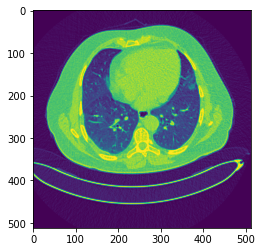

Malignant cases


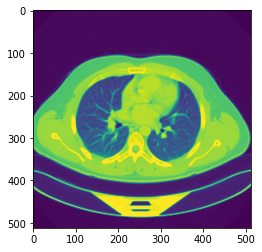

Normal cases


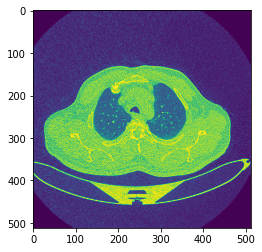

In [8]:
for i in categories:
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        print(i)
        img = cv2.imread(filepath, 0)
        plt.imshow(img)
        plt.show()
        break

# *Image Preprocessing*

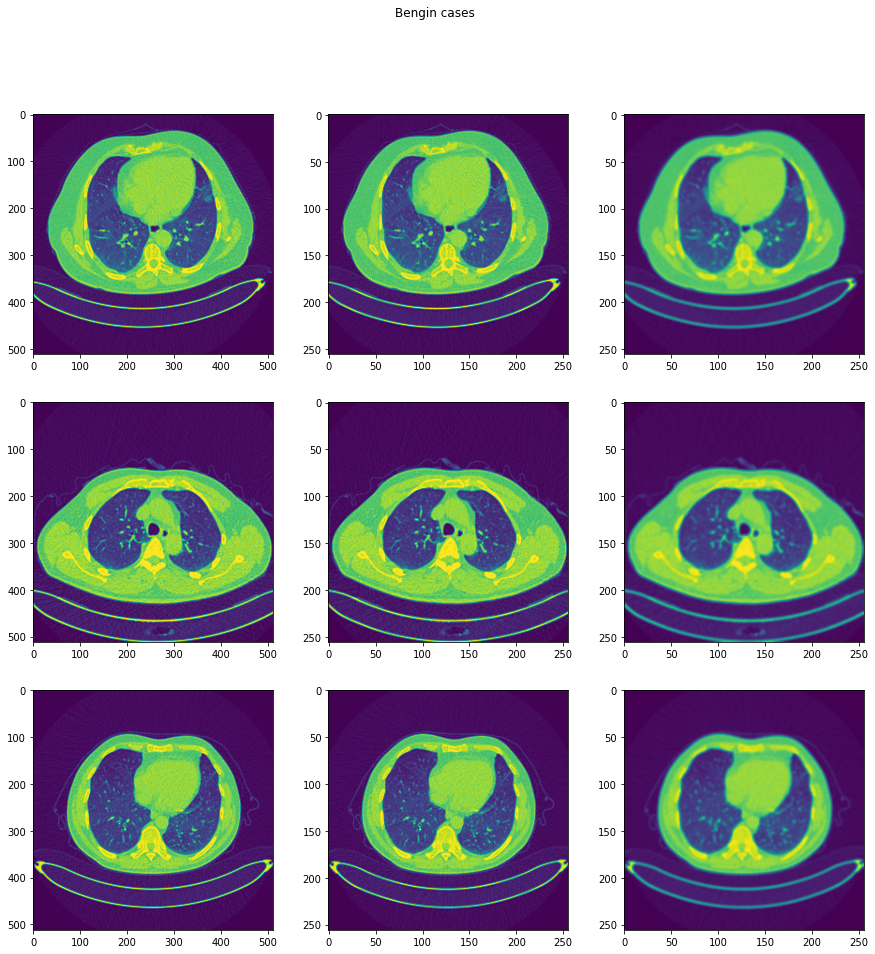

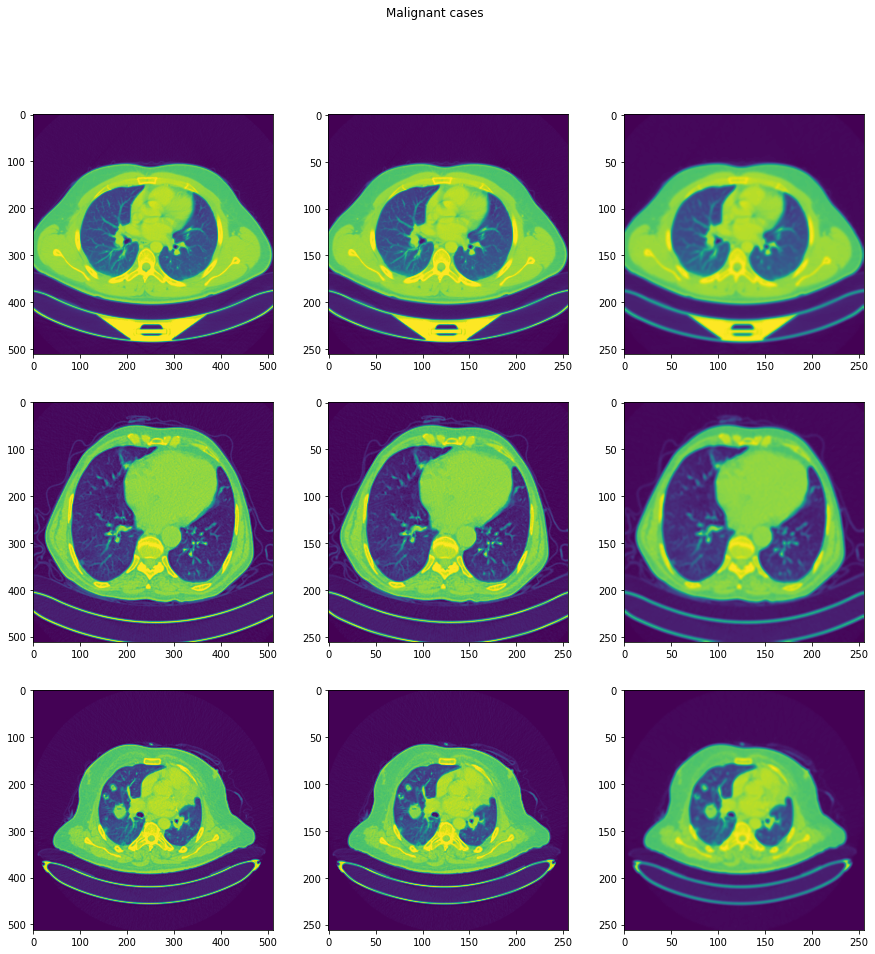

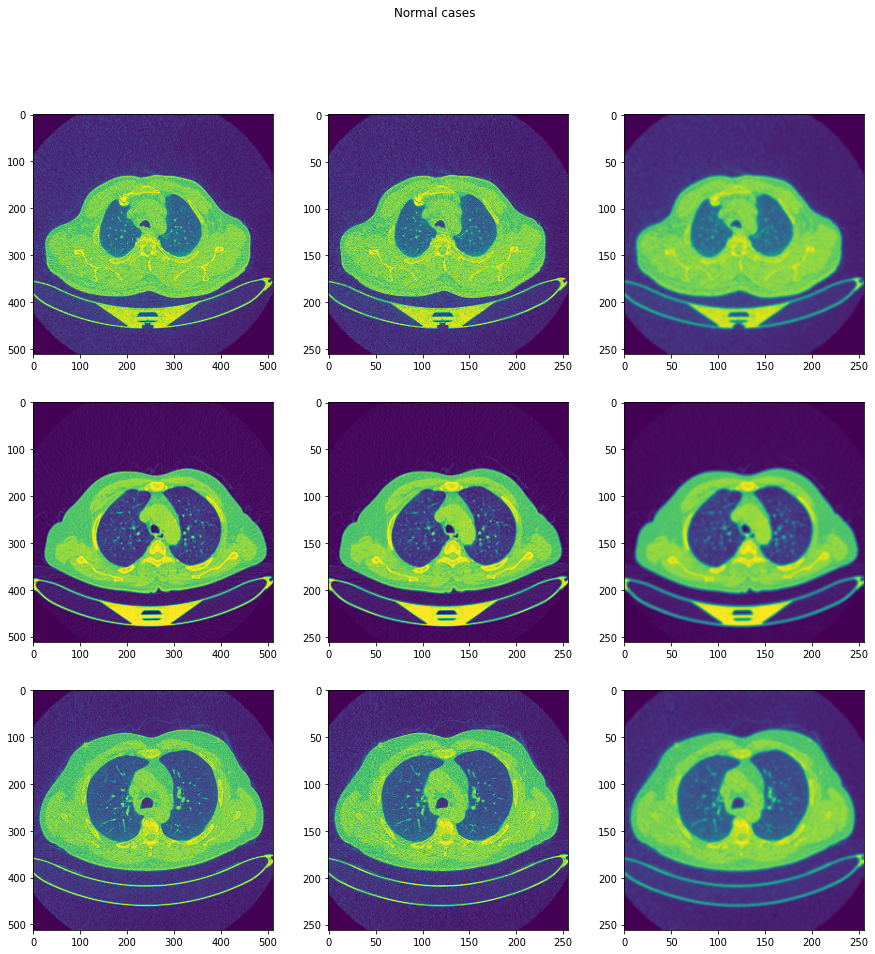

In [9]:
img_size = 256
for i in categories:
    cnt, samples = 0, 3
    fig, ax = plt.subplots(samples, 3, figsize=(15, 15))
    fig.suptitle(i)
    
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    for curr_cnt, file in enumerate(os.listdir(path)):
        filepath = os.path.join(path, file)
        img = cv2.imread(filepath, 0)
        
        img0 = cv2.resize(img, (img_size, img_size))
        
        img1 = cv2.GaussianBlur(img0, (5, 5), 0)
        
        ax[cnt, 0].imshow(img)
        ax[cnt, 1].imshow(img0)
        ax[cnt, 2].imshow(img1)
        cnt += 1
        if cnt == samples:
            break
        
plt.show() 

In [10]:
data = []
img_size = 256

for i in categories:
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        img = cv2.imread(filepath, 0)
        # preprocess here
        img = cv2.resize(img, (img_size, img_size))
        data.append([img, class_num])
        
random.shuffle(data)

X, y = [], []
for feature, label in data:
    X.append(feature)
    y.append(label)
    

In [11]:
# normalize
X = np.array(X).reshape(-1, img_size, img_size, 1)
X = X / 255.0
y = np.array(y)

In [12]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=10, stratify=y)

In [13]:
X_train = X_train.reshape(X_train.shape[0], img_size*img_size*1)

In [14]:
print('Before SMOTE:', Counter(y_train))
smote = SMOTE()
X_train_sampled, y_train_sampled = smote.fit_resample(X_train, y_train)
print('After SMOTE:', Counter(y_train_sampled))

Before SMOTE: Counter({1: 420, 2: 312, 0: 90})
After SMOTE: Counter({2: 420, 1: 420, 0: 420})


In [15]:
X_train = X_train.reshape(X_train.shape[0], img_size, img_size, 1)
X_train_sampled = X_train_sampled.reshape(X_train_sampled.shape[0], img_size, img_size, 1)

print(len(X_train), X_train.shape)
print(len(X_train_sampled), X_train_sampled.shape)

822 (822, 256, 256, 1)
1260 (1260, 256, 256, 1)


# *Model building*

In [16]:
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=X_train.shape[1:], activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128))
model.add(Dropout(0.6))
model.add(Dense(3, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      320       
                                                                 
 conv2d_1 (Conv2D)           (None, 252, 252, 32)      9248      
                                                                 
 batch_normalization (BatchN  (None, 252, 252, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 126, 126, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 126, 126, 32)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 124, 124, 64)      1

In [17]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# *Model training*

In [18]:
history = model.fit(X_train_sampled, y_train_sampled, batch_size=8, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10
158/158 [==============================] - 31s 130ms/step - loss: 71.3921 - accuracy: 0.7294 - val_loss: 380.7042 - val_accuracy: 0.2909
Epoch 2/10
158/158 [==============================] - 19s 117ms/step - loss: 16.8940 - accuracy: 0.9159 - val_loss: 243.0325 - val_accuracy: 0.4109
Epoch 3/10
158/158 [==============================] - 19s 118ms/step - loss: 13.8610 - accuracy: 0.9405 - val_loss: 24.5206 - val_accuracy: 0.8000
Epoch 4/10
158/158 [==============================] - 18s 116ms/step - loss: 5.2108 - accuracy: 0.9762 - val_loss: 38.2125 - val_accuracy: 0.8400
Epoch 5/10
158/158 [==============================] - 18s 116ms/step - loss: 12.7929 - accuracy: 0.9579 - val_loss: 9.8775 - val_accuracy: 0.9527
Epoch 6/10
158/158 [==============================] - 18s 116ms/step - loss: 6.5158 - accuracy: 0.9722 - val_loss: 3.9663 - val_accuracy: 0.9855
Epoch 7/10
158/158 [==============================] - 18s 115ms/step - loss: 4.6043 - accuracy: 0.9778 - val_loss: 2.636

In [19]:
y_pred = model.predict(X_valid, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_valid, y_pred_bool))

print(confusion_matrix(y_true=y_valid, y_pred=y_pred_bool))

9/9 [==============================] - 4s 229ms/step
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        30
           1       0.92      1.00      0.96       141
           2       0.99      0.87      0.92       104

    accuracy                           0.95       275
   macro avg       0.96      0.94      0.95       275
weighted avg       0.95      0.95      0.94       275

[[ 29   0   1]
 [  0 141   0]
 [  1  13  90]]


# *Displaying results on a chart*

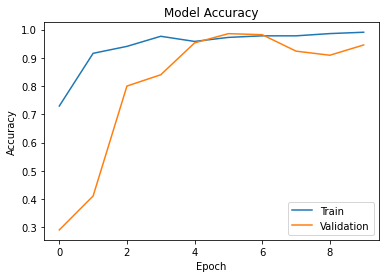

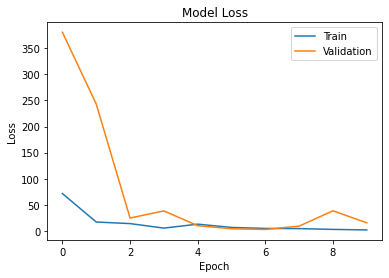

In [20]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# **Data Augmentation**

In [26]:
train_datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True) 
val_datagen = ImageDataGenerator()
train_generator = train_datagen.flow(X_train, y_train, batch_size=8) 
val_generator = val_datagen.flow(X_valid, y_valid, batch_size=8)

In [36]:
model2 = Sequential()

model2.add(Conv2D(64, (3, 3), input_shape=X_train.shape[1:], activation = 'relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Flatten())
model2.add(Dense(16))
model2.add(Dense(3, activation='softmax'))

model2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 254, 254, 64)      640       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 127, 127, 64)     0         
 2D)                                                             
                                                                 
 conv2d_20 (Conv2D)          (None, 125, 125, 64)      36928     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 246016)            0         
                                                                 
 dense_9 (Dense)             (None, 16)               

In [38]:
model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [39]:
history = model2.fit_generator(train_generator, epochs=10, validation_data=val_generator)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


103/103 [==============================] - 9s 73ms/step - loss: 1.1762 - accuracy: 0.6168 - val_loss: 0.7688 - val_accuracy: 0.6109
Epoch 2/10
103/103 [==============================] - 7s 64ms/step - loss: 0.5377 - accuracy: 0.7993 - val_loss: 0.3972 - val_accuracy: 0.8909
Epoch 3/10
103/103 [==============================] - 7s 64ms/step - loss: 0.3035 - accuracy: 0.9015 - val_loss: 0.2858 - val_accuracy: 0.8764
Epoch 4/10
103/103 [==============================] - 7s 64ms/step - loss: 0.1723 - accuracy: 0.9416 - val_loss: 0.2408 - val_accuracy: 0.9309
Epoch 5/10
103/103 [==============================] - 7s 64ms/step - loss: 0.1230 - accuracy: 0.9611 - val_loss: 0.1362 - val_accuracy: 0.9418
Epoch 6/10
103/103 [==============================] - 7s 64ms/step - loss: 0.1088 - accuracy: 0.9647 - val_loss: 0.1551 - val_accuracy: 0.9491
Epoch 7/10
103/103 [==============================] - 7s 65ms/step - loss: 0.0649 - accuracy: 0.9805 - val_loss: 0.0754 - val_accuracy: 0.9745
Epoch 8/10

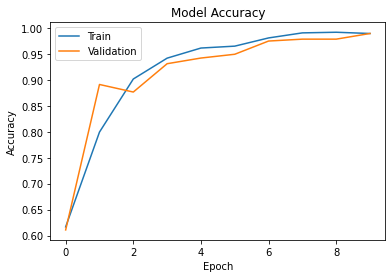

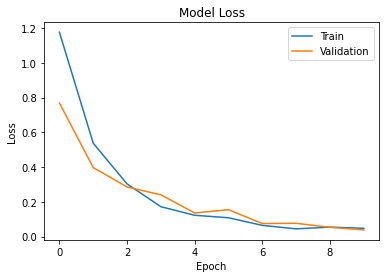

In [40]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [41]:
y_pred = model2.predict(X_valid, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_valid, y_pred_bool))

print(confusion_matrix(y_true=y_valid, y_pred=y_pred_bool))

9/9 [==============================] - 2s 122ms/step
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        30
           1       1.00      0.99      0.99       141
           2       0.98      1.00      0.99       104

    accuracy                           0.99       275
   macro avg       0.98      0.98      0.98       275
weighted avg       0.99      0.99      0.99       275

[[ 29   0   1]
 [  1 139   1]
 [  0   0 104]]
